In [1]:
import os
os.environ['KERAS_BACKEND'] = 'jax'

In [2]:
from dataclasses import dataclass
from pathlib import Path
import numpy as np
from numpy.typing import NDArray
import keras
import h5py as h5
from keras import ops
from keras import layers
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve



In [3]:
from hgq.layers import QDense, QAdd
from hgq.config import QuantizerConfigScope, LayerConfigScope
from hgq.utils import trace_minmax
from hgq.utils.sugar import FreeEBOPs, BetaScheduler, PieceWiseSchedule


In [4]:
def get_scale_and_shift(x: NDArray[np.float32]):
    _scale, _mean = np.empty((19,3)), np.empty((19,3))
    for i in range(19):
        mask = x[:,i,0] != 0
        _scale[i] = np.std(x[:,i], axis=0)
        _mean[i] = np.mean(x[:,i], axis=0)
    return _scale+1e-6, _mean

@dataclass
class ADDataset:
    qcd_train: NDArray[np.float16]
    qcd_val: NDArray[np.float16]
    qcd_test: NDArray[np.float16]
    hChToTauNu: NDArray[np.float16]
    Ato4l: NDArray[np.float16]
    leptoquark: NDArray[np.float16]
    hToTauTau: NDArray[np.float16]
    
    @classmethod
    def load_h5(cls, path: Path|str, train_frac=0.7, val_frac=0.15):
        path = Path(path)
        with h5.File(path / 'Ato4l_lepFilter_13TeV_filtered.h5') as f:
            Ato4l: np.ndarray = f['Particles'][:,:,:3] # type: ignore
        with h5.File(path / 'hChToTauNu_13TeV_PU20_filtered.h5') as f:
            hChToTauNu: np.ndarray = f['Particles'][:,:,:3] # type: ignore
        with h5.File(path / 'leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5') as f:
            leptoquark: np.ndarray = f['Particles'][:,:,:3] # type: ignore
        with h5.File(path / 'background_for_training.h5') as f:
            qcd: np.ndarray = f['Particles'][:,:,:3] # type: ignore
        with h5.File(path / 'hToTauTau_13TeV_PU20_filtered.h5') as f:
            hToTauTau: np.ndarray = f['Particles'][:,:,:3] # type: ignore

        np.random.shuffle(qcd)

        n_train = int(len(qcd) * train_frac)
        n_val = int(len(qcd) * val_frac)

        qcd_train = qcd[:n_train]
        qcd_val = qcd[n_train:n_train+n_val]
        qcd_test = qcd[n_train+n_val:]

        _scale, _shift = get_scale_and_shift(qcd_train.astype(np.float32))
        
        def norm(x: np.ndarray) -> np.ndarray:
            return (x - _shift) / _scale
            return np.clip(a, -1, 1)

        qcd_train = norm(qcd_train)
        qcd_val = norm(qcd_val)
        qcd_test = norm(qcd_test)
        hChToTauNu = norm(hChToTauNu)
        Ato4l = norm(Ato4l)
        leptoquark = norm(leptoquark)
        hToTauTau = norm(hToTauTau)
        
        return cls(
            qcd_train=qcd_train.astype(np.float16),
            qcd_val=qcd_val.astype(np.float16),
            qcd_test=qcd_test.astype(np.float16),
            hChToTauNu=hChToTauNu.astype(np.float16),
            Ato4l=Ato4l.astype(np.float16),
            leptoquark=leptoquark.astype(np.float16),
            hToTauTau=hToTauTau.astype(np.float16)
        )
        
    def dump(self, path: Path|str):
        path = Path(path)
        path.mkdir(parents=True, exist_ok=True)
        np.savez_compressed(
            path / 'addataset.npz',
            qcd_train=self.qcd_train,
            qcd_val=self.qcd_val,
            qcd_test=self.qcd_test,
            hChToTauNu=self.hChToTauNu,
            Ato4l=self.Ato4l,
            leptoquark=self.leptoquark,
            hToTauTau=self.hToTauTau
        )
    
    @classmethod
    def load_npz(cls, path: Path|str):
        path = Path(path)
        data = np.load(path / 'addataset.npz')
        return cls(
            qcd_train=data['qcd_train'],
            qcd_val=data['qcd_val'],
            qcd_test=data['qcd_test'],
            hChToTauNu=data['hChToTauNu'],
            Ato4l=data['Ato4l'],
            leptoquark=data['leptoquark'],
            hToTauTau=data['hToTauTau']
        )

In [5]:
# dataset_np = ADDataset.load_h5('/mnt/hdd2/dataset/adc2021/')

In [6]:
# dataset_np.dump('/tmp/cache_ss.npz')

In [7]:
dataset_np = ADDataset.load_npz('/tmp/cache_ss.npz')

In [8]:
inp = keras.Input(shape=(19, 3))
t_inp = keras.Input(shape=(1,1))
inp_flat = layers.Flatten()(inp)
t_flat = layers.Flatten()(t_inp)

# x = layers.Dense(32)(t_flat) + layers.Dense(32)(inp_flat)
# x = layers.ReLU()(x)
# x = layers.Dense(32, activation='relu')(x)
# x = layers.Dense(57)(x)
# x = layers.Reshape((19, 3))(x)
# model = keras.Model(inputs=[inp, t_inp], outputs=x)

with QuantizerConfigScope(b0=8, f0=6), LayerConfigScope(beta0=0.5e-6):
    x = QDense(32)(t_flat) + QDense(32)(inp_flat)
    x = layers.ReLU()(x)
    x = QDense(32, activation='relu')(x)
    x = QDense(57)(x)
    x = layers.Reshape((19, 3))(x)
    model = keras.Model(inputs=[inp, t_inp], outputs=x)


In [9]:
from kfm import FMWrapper

In [10]:
# model:keras.Model = keras.models.load_model('/tmp/syn.keras')/

In [11]:
fm_model = FMWrapper(model)

In [12]:
def loss(y_true, y_pred):
    return y_pred

In [13]:
fm_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss=loss, steps_per_execution=8)
fm_model.build([(None, 19, 3), (None, 1, 1)])

In [14]:
from hgq.utils.sugar import Dataset, PBar

In [15]:
dataset_train = Dataset(dataset_np.qcd_train, batch_size=1024, drop_last=True, device='gpu:0')
dataset_val = Dataset(dataset_np.qcd_val, batch_size=8192, drop_last=False, device='gpu:0')

In [16]:
pbar = PBar()
ebops = FreeEBOPs()
sched = BetaScheduler(lambda ep: 1e-6 if ep < 50 else 5e-6)

In [17]:
callbacks = [ebops, pbar, sched]

In [18]:
fm_model.fit(dataset_train, validation_data=dataset_val, epochs=100, callbacks=callbacks, verbose=0)

  0%|          | 0/100 [00:00<?, ?epoch/s]

loss: 1.58/1.55 - EBOPs: 7,734: 100%|██████████| 100/100 [08:20<00:00,  5.01s/epoch] 


In [19]:
from hgq.utils import trace_minmax

In [20]:
N = len(dataset_np.qcd_train) + len(dataset_np.qcd_val)
ones = np.ones((N, 1, 1), dtype=np.float16)
ds_trace = Dataset([np.concatenate([dataset_np.qcd_train, dataset_np.qcd_val], axis=0), ones], batch_size=16384, drop_last=False, device='gpu:0')

In [21]:
trace_minmax(fm_model.base_model, ds_trace, verbose=2)

  0%|          | 0/698 [00:00<?, ?it/s]

q_dense  : 71
q_dense_1: 3010
q_dense_2: 2416
q_dense_3: 1829
Total: 7326


7326

In [22]:
fm_model.base_model.save('/tmp/syn-traced2.keras')

In [23]:
x0 = np.random.randn(1310720, 19, 3).astype(np.float16)

In [24]:
x1 = fm_model.sample(x0, np.linspace(0, 1, 100), batch_size=16384*4)
t1 = fm_model.sample(x0[:1000], np.linspace(0, 1, 100), batch_size=1000, return_trajectories=True)

In [25]:
# x00 = fm_model.sample(dataset_np.qcd_test[:16384], np.linspace(1, 0, 512), batch_size=16384)
# # x01 = fm_model.sample(x00, np.linspace(0, 1, 1000), batch_size=16384)

# t00 = fm_model.sample(x00, np.linspace(0, 1, 128), batch_size=16384, return_trajectories=True)
# t01 = fm_model.sample(x00, np.linspace(0, 1, 64), batch_size=16384, return_trajectories=True)
# t02 = fm_model.sample(x00, np.linspace(0, 1, 16), batch_size=16384, return_trajectories=True)
# t03 = fm_model.sample(x00, np.linspace(0, 1, 8), batch_size=16384, return_trajectories=True)

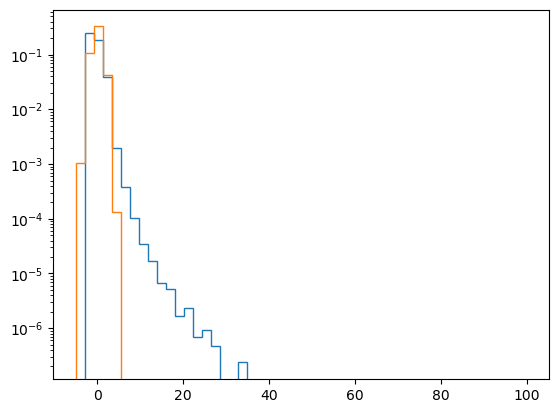

In [26]:
i,j = 5,0
plt.hist(dataset_np.qcd_test[:,i,j], bins=50, range=(-5, 100), density=True, histtype='step')
plt.hist(x1[:,i,j], bins=50, range=(-5, 100), density=True, histtype='step')
plt.yscale('log')
plt.show()

In [27]:
# t00.shape

In [28]:
# plt.plot(np.linspace(0,1,len(t00[:,:100,i,j])),t00[:,:100,i,j])
# plt.plot(np.linspace(0,1,len(t01[:,:20,i,j])),t01[:,:20,i,j])
# plt.plot(np.linspace(0,1,len(t02[:,:20,i,j])),t02[:,:20,i,j])
# plt.plot(np.linspace(0,1,len(t03[:,:20,i,j])),t03[:,:20,i,j])
# plt.hist(x00[:,[0,1,5,9],0], bins=50, range=(-5, 5), density=True, histtype='step')
# plt.hist(np.random.randn(16384), bins=50, color='k',range=(-5, 5), density=True, histtype='step')
# plt.show()

In [29]:
mode = 1
v_qcd = fm_model.predict_score(dataset_np.qcd_test, batch_size=16384, mode=mode)
v_hChToTauNu = fm_model.predict_score(dataset_np.hChToTauNu, batch_size=16384, mode=mode)
v_Ato4l = fm_model.predict_score(dataset_np.Ato4l, batch_size=16384, mode=mode)
v_leptoquark = fm_model.predict_score(dataset_np.leptoquark, batch_size=16384, mode=mode)
v_hToTauTau = fm_model.predict_score(dataset_np.hToTauTau, batch_size=16384, mode=mode)

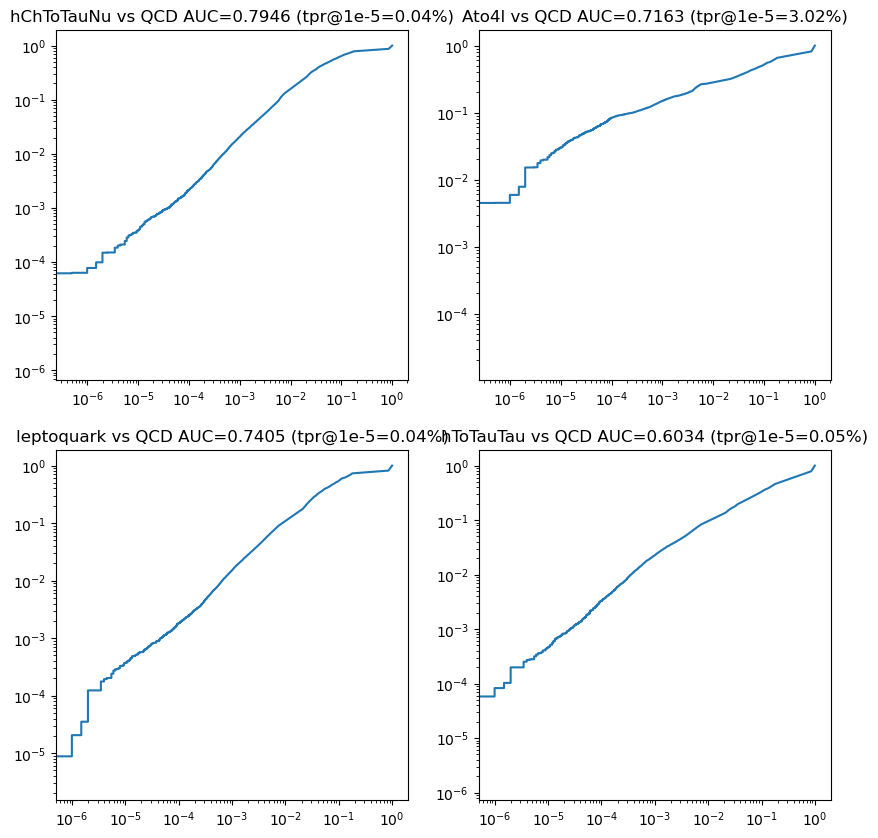

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))

_label = np.array([0]*len(v_qcd) + [1]*len(v_hChToTauNu))
fpt, tpr, _ = roc_curve(_label, np.concatenate([v_qcd, v_hChToTauNu]))
_tpr = np.interp(1e-5, fpt, tpr)
auc = np.trapezoid(tpr, fpt)
axs[0,0].plot(fpt, tpr)
axs[0,0].set_title(f'hChToTauNu vs QCD AUC={auc:.4f} (tpr@1e-5={_tpr:.2%})')
axs[0,0].set_xscale('log')
axs[0,0].set_yscale('log')

_label = np.array([0]*len(v_qcd) + [1]*len(v_Ato4l))
fpt, tpr, _ = roc_curve(_label, np.concatenate([v_qcd, v_Ato4l]))
_tpr = np.interp(1e-5, fpt, tpr)
auc = np.trapezoid(tpr, fpt)
axs[0,1].plot(fpt, tpr)
axs[0,1].set_title(f'Ato4l vs QCD AUC={auc:.4f} (tpr@1e-5={_tpr:.2%})')
axs[0,1].set_xscale('log')
axs[0,1].set_yscale('log')

_label = np.array([0]*len(v_qcd) + [1]*len(v_leptoquark))
fpt, tpr, _ = roc_curve(_label, np.concatenate([v_qcd, v_leptoquark]))
_tpr = np.interp(1e-5, fpt, tpr)
auc = np.trapezoid(tpr, fpt)
axs[1,0].plot(fpt, tpr)
axs[1,0].set_title(f'leptoquark vs QCD AUC={auc:.4f} (tpr@1e-5={_tpr:.2%})')
axs[1,0].set_xscale('log')
axs[1,0].set_yscale('log')

_label = np.array([0]*len(v_qcd) + [1]*len(v_hToTauTau))
fpt, tpr, _ = roc_curve(_label, np.concatenate([v_qcd, v_hToTauTau]))
_tpr = np.interp(1e-5, fpt, tpr)
auc = np.trapezoid(tpr, fpt)
axs[1,1].plot(fpt, tpr)
axs[1,1].set_title(f'hToTauTau vs QCD AUC={auc:.4f} (tpr@1e-5={_tpr:.2%})')
axs[1,1].set_xscale('log')
axs[1,1].set_yscale('log')

plt.show()

In [31]:
# v_ode_qcd = fm_model.sample(dataset_np.qcd_test, batch_size=16384, ts=np.linspace(1,0,32))
# v_ode_hChToTauNu = fm_model.sample(dataset_np.hChToTauNu, batch_size=16384, ts=np.linspace(1,0,32))
# v_ode_Ato4l = fm_model.sample(dataset_np.Ato4l, batch_size=16384, ts=np.linspace(1,0,32))
# v_ode_leptoquark = fm_model.sample(dataset_np.leptoquark, batch_size=16384, ts=np.linspace(1,0,32))
# v_ode_hToTauTau = fm_model.sample(dataset_np.hToTauTau, batch_size=16384, ts=np.linspace(1,0,32))

In [32]:
# v_ode_qcd = np.sum(v_ode_qcd**2, axis=(1,2))
# v_ode_hChToTauNu = np.sum(v_ode_hChToTauNu**2, axis=(1,2))
# v_ode_Ato4l = np.sum(v_ode_Ato4l**2, axis=(1,2))
# v_ode_leptoquark = np.sum(v_ode_leptoquark**2, axis=(1,2))
# v_ode_hToTauTau = np.sum(v_ode_hToTauTau**2, axis=(1,2))

In [33]:
# fig, axs = plt.subplots(2, 2, figsize=(10,10))

# _label = np.array([0]*len(v_qcd) + [1]*len(v_hChToTauNu))
# fpt, tpr, _ = roc_curve(_label, np.concatenate([v_ode_qcd, v_ode_hChToTauNu]))
# auc = np.trapezoid(tpr, fpt)
# axs[0,0].plot(fpt, tpr)
# axs[0,0].set_title(f'hChToTauNu vs QCD AUC={auc:.4f}')
# axs[0,0].set_xscale('log')
# axs[0,0].set_yscale('log')

# _label = np.array([0]*len(v_qcd) + [1]*len(v_Ato4l))
# fpt, tpr, _ = roc_curve(_label, np.concatenate([v_ode_qcd, v_ode_Ato4l]))
# auc = np.trapezoid(tpr, fpt)
# axs[0,1].plot(fpt, tpr)
# axs[0,1].set_title(f'Ato4l vs QCD AUC={auc:.4f}')
# axs[0,1].set_xscale('log')
# axs[0,1].set_yscale('log')

# _label = np.array([0]*len(v_qcd) + [1]*len(v_leptoquark))
# fpt, tpr, _ = roc_curve(_label, np.concatenate([v_ode_qcd, v_ode_leptoquark]))
# auc = np.trapezoid(tpr, fpt)
# axs[1,0].plot(fpt, tpr)
# axs[1,0].set_title(f'leptoquark vs QCD AUC={auc:.4f}')
# axs[1,0].set_xscale('log')
# axs[1,0].set_yscale('log')

# _label = np.array([0]*len(v_qcd) + [1]*len(v_hToTauTau))
# fpt, tpr, _ = roc_curve(_label, np.concatenate([v_ode_qcd, v_ode_hToTauTau]))
# auc = np.trapezoid(tpr, fpt)
# axs[1,1].plot(fpt, tpr)
# axs[1,1].set_title(f'hToTauTau vs QCD AUC={auc:.4f}')
# axs[1,1].set_xscale('log')
# axs[1,1].set_yscale('log')

# plt.show()

In [34]:
# model:keras.Model = keras.models.load_model('/tmp/syn-traced.keras')

In [35]:
from da4ml.converter import trace_model
from da4ml.codegen import RTLModel
from da4ml.trace import FixedVariableArrayInput, HWConfig, comb_trace

In [36]:
inp0 = FixedVariableArrayInput((19,3), hwconf=HWConfig(1,8,-1))
inp1 = np.ones((1,1), dtype=np.float16)

In [37]:
inp, out = trace_model(model, inputs=[inp0, inp1])

out = out.quantize(1, 10, 3)
out = out ** 2
out = out.quantize(0, 26, 0)
out = np.sum(out)

In [38]:
comb = comb_trace(inp, out)
comb

Solution([57 -> 1], cost=12069.0, latency=68.0-68.0)

In [39]:
emu_qcd = comb.predict(dataset_np.qcd_test) 
emu_hChToTauNu = comb.predict(dataset_np.hChToTauNu)
emu_Ato4l = comb.predict(dataset_np.Ato4l)
emu_leptoquark = comb.predict(dataset_np.leptoquark)
emu_hToTauTau = comb.predict(dataset_np.hToTauTau)

In [40]:
rtl_model = RTLModel(
    comb,
    prj_name='test',
    path='/tmp/rtl4',
    flavor='verilog',
    latency_cutoff=6,
    clock_uncertainty=0.,
    part_name='xcu250-figd2104-2L-e'
)

In [41]:
rtl_model

Top Module: test
57 (374 bits) -> 1 (24 bits)
12 stages @ max_delay=6
Estimated cost: 12069 LUTs, 5162 FFs
Emulator is **not compiled**

In [42]:
rtl_model.compile()

In [43]:
rtl_qcd = rtl_model.predict(dataset_np.qcd_test)
rtl_hChToTauNu = rtl_model.predict(dataset_np.hChToTauNu)
rtl_Ato4l = rtl_model.predict(dataset_np.Ato4l)
rtl_leptoquark = rtl_model.predict(dataset_np.leptoquark)
rtl_hToTauTau = rtl_model.predict(dataset_np.hToTauTau)

In [44]:
assert np.all(emu_qcd == rtl_qcd)
assert np.all(emu_hChToTauNu == rtl_hChToTauNu)
assert np.all(emu_Ato4l == rtl_Ato4l)
assert np.all(emu_leptoquark == rtl_leptoquark)
assert np.all(emu_hToTauTau == rtl_hToTauTau)

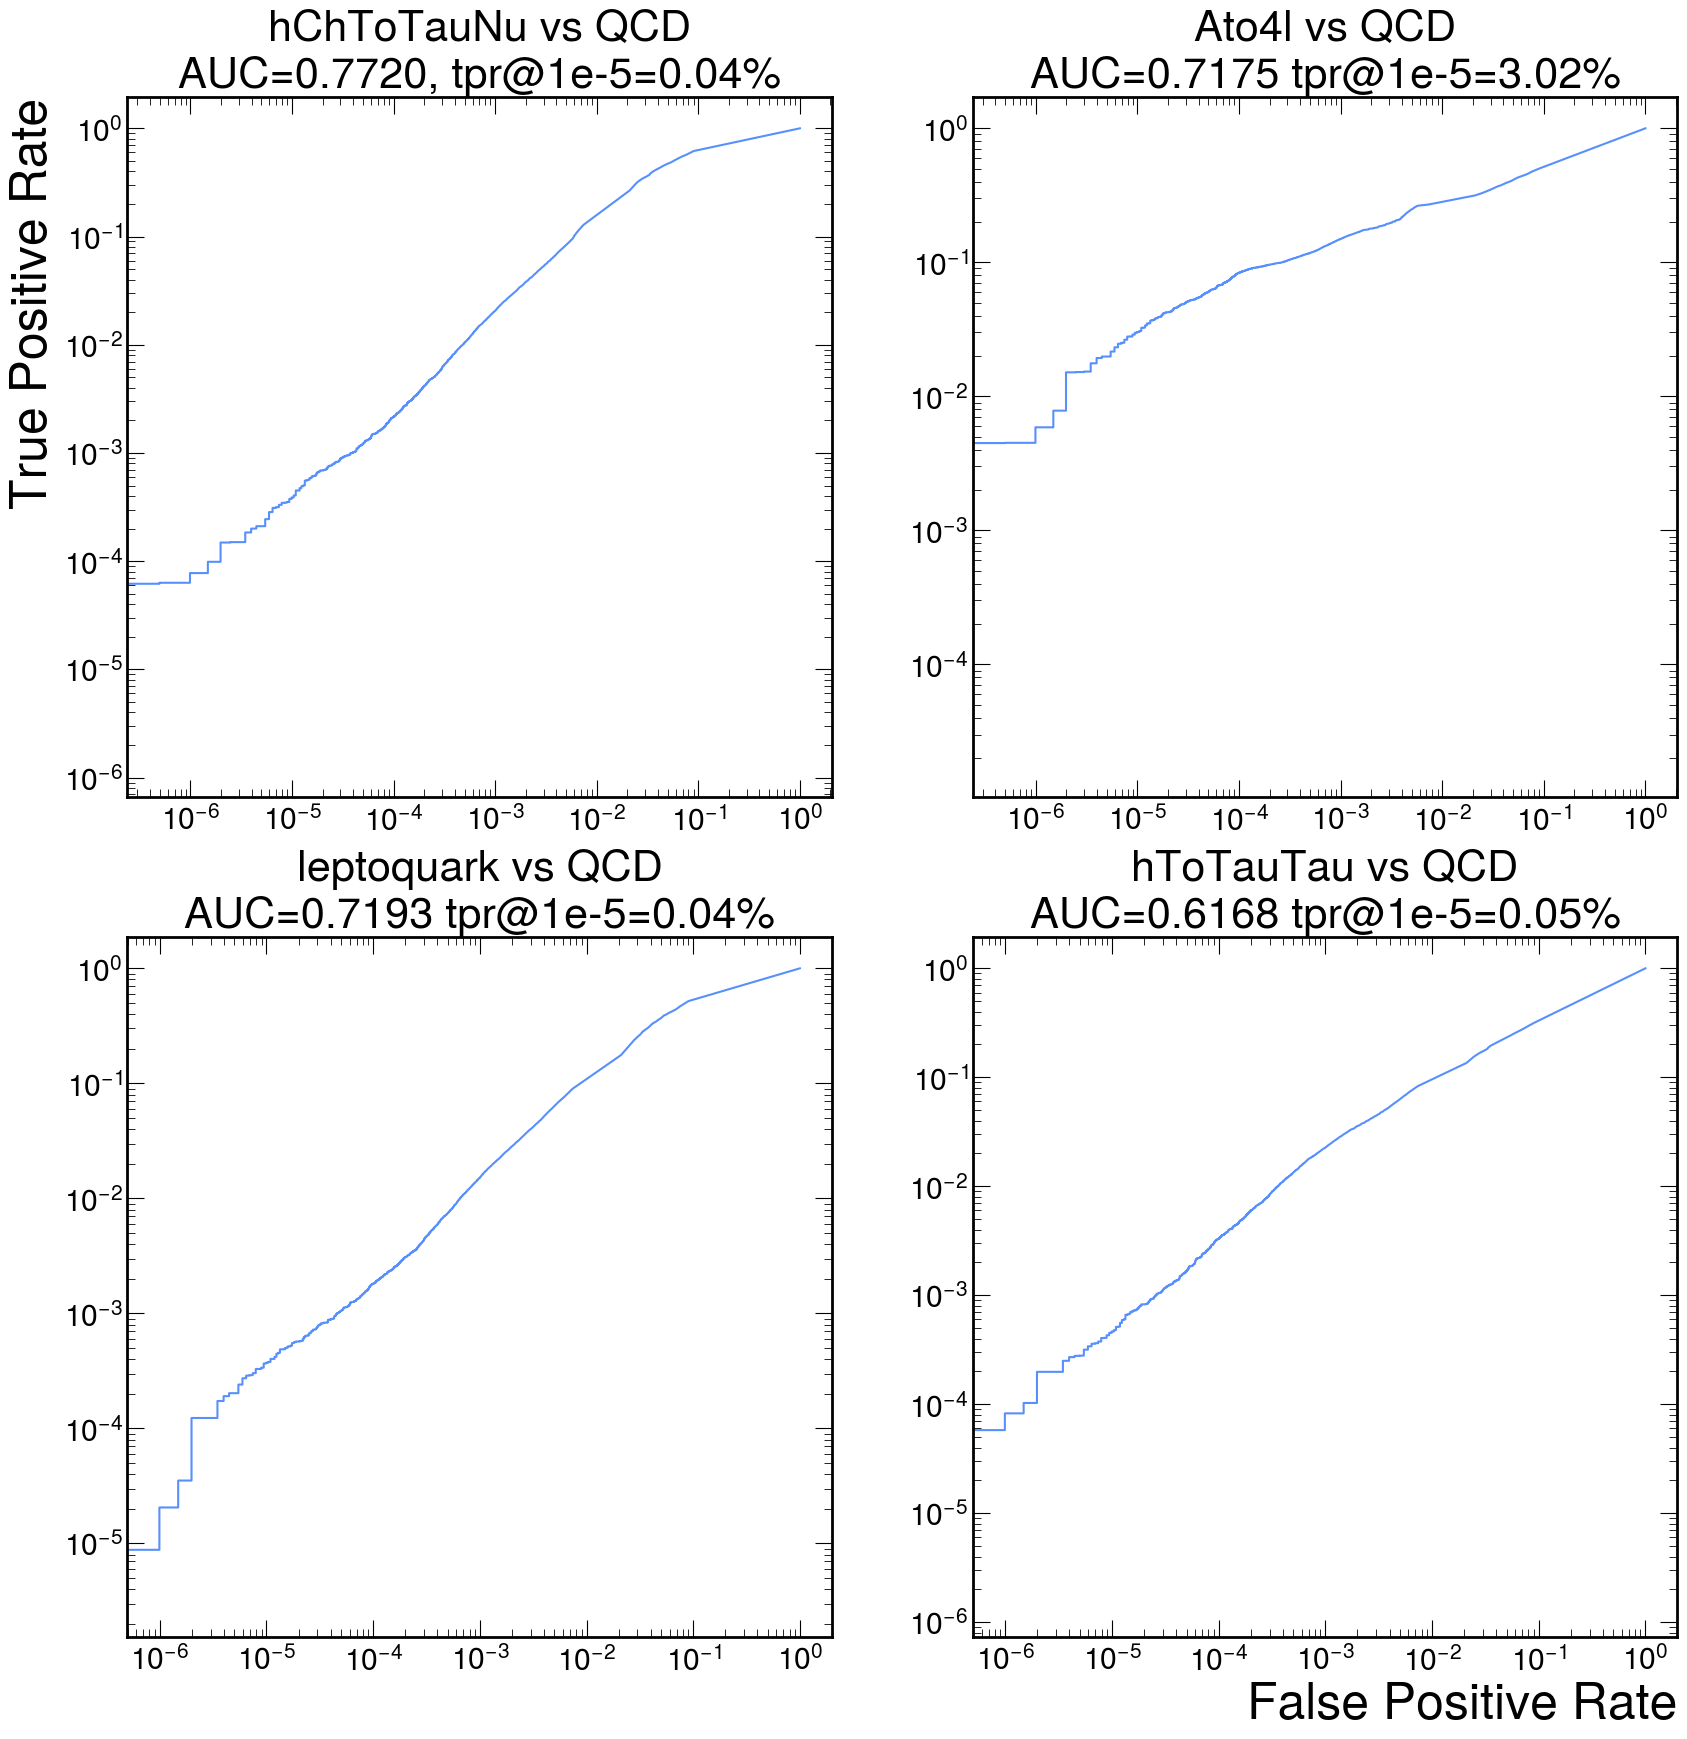

In [45]:
import mplhep as hep
hep.style.use('CMS')

fig, axs = plt.subplots(2, 2, figsize=(20,20))

_label = np.array([0]*len(rtl_qcd) + [1]*len(rtl_hChToTauNu))
fpt, tpr, _ = roc_curve(_label, np.concatenate([rtl_qcd, rtl_hChToTauNu]))
_tpr = np.interp(1e-5, fpt, tpr)
auc = np.trapezoid(tpr, fpt)
axs[0,0].plot(fpt, tpr)
axs[0,0].set_title(f'hChToTauNu vs QCD\nAUC={auc:.4f}, tpr@1e-5={_tpr:.2%}')
axs[0,0].set_xscale('log')
axs[0,0].set_yscale('log')
axs[0,0].set_ylabel('True Positive Rate', fontsize=36)

_label = np.array([0]*len(rtl_qcd) + [1]*len(rtl_Ato4l))
fpt, tpr, _ = roc_curve(_label, np.concatenate([rtl_qcd, rtl_Ato4l]))
_tpr = np.interp(1e-5, fpt, tpr)
auc = np.trapezoid(tpr, fpt)
axs[0,1].plot(fpt, tpr)
axs[0,1].set_title(f'Ato4l vs QCD\nAUC={auc:.4f} tpr@1e-5={_tpr:.2%}')
axs[0,1].set_xscale('log')
axs[0,1].set_yscale('log')

_label = np.array([0]*len(rtl_qcd) + [1]*len(rtl_leptoquark))
fpt, tpr, _ = roc_curve(_label, np.concatenate([rtl_qcd, rtl_leptoquark]))
_tpr = np.interp(1e-5, fpt, tpr)
auc = np.trapezoid(tpr, fpt)
axs[1,0].plot(fpt, tpr)
axs[1,0].set_title(f'leptoquark vs QCD\nAUC={auc:.4f} tpr@1e-5={_tpr:.2%}')
axs[1,0].set_xscale('log')
axs[1,0].set_yscale('log')

_label = np.array([0]*len(rtl_qcd) + [1]*len(rtl_hToTauTau))
fpt, tpr, _ = roc_curve(_label, np.concatenate([rtl_qcd, rtl_hToTauTau]))
_tpr = np.interp(1e-5, fpt, tpr)
auc = np.trapezoid(tpr, fpt)
axs[1,1].plot(fpt, tpr)
axs[1,1].set_title(f'hToTauTau vs QCD\nAUC={auc:.4f} tpr@1e-5={_tpr:.2%}')
axs[1,1].set_xscale('log')
axs[1,1].set_yscale('log')
axs[1,1].set_xlabel('False Positive Rate', fontsize=36)

plt.savefig('/tmp/roc-small.pdf', bbox_inches='tight')

In [46]:
bits = []
for layers in model.layers:
    if not isinstance(layers, QDense):
        continue
    bits.append(np.array(layers.kq.bits).ravel())
bits = np.concatenate(bits)

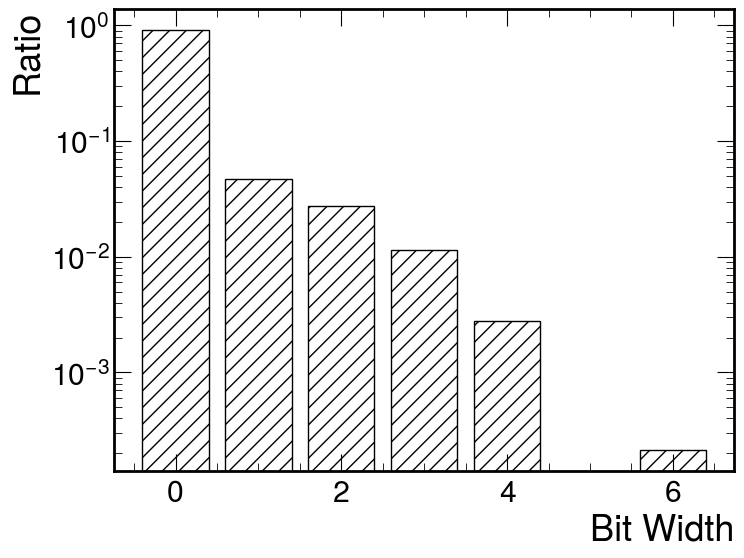

In [47]:
fig, axs = plt.subplots(1, 1, figsize=(8,6))
b, n = np.unique(bits, return_counts=True)
n=n/np.sum(n)
plt.bar(b, n, hatch='//', facecolor='none', edgecolor='black')
plt.yscale('log')
plt.xlabel('Bit Width')
plt.ylabel('Ratio')
plt.savefig('/tmp/weight_bits.pdf', bbox_inches='tight')

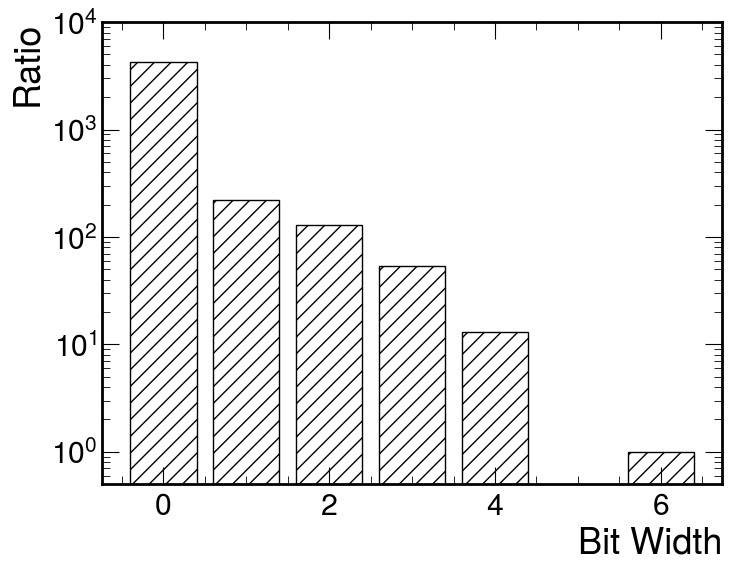

In [50]:
fig, axs = plt.subplots(1, 1, figsize=(8,6))
b, n = np.unique(bits, return_counts=True)
# n=n/np.sum(n)
plt.bar(b, n, hatch='//', facecolor='none', edgecolor='black')
plt.yscale('log')
plt.xlabel('Bit Width')
plt.ylabel('Ratio')
plt.ylim(0.5, 1e4)
plt.savefig('/tmp/weight_bits_n.pdf', bbox_inches='tight')

In [53]:
np.round(n/np.sum(n), 3)

array([0.911, 0.047, 0.028, 0.011, 0.003, 0.   ])